## Programming Assignment - 3: Recurrent Neural Networks

## Loading the data

In [15]:
# import packages
import random
import numpy as np
import seaborn as sns
import cv2 as cv
import matplotlib.pyplot as plt
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## 1. MNIST classification using RNN

In [2]:
mnist_train = torchvision.datasets.MNIST(root = 'MNIST', download = True, transform = transforms.ToTensor())
mnist_data_test = torchvision.datasets.MNIST(root = 'MNIST', train = False, download = True, transform = transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



In [3]:
train_indices, val_indices, _, _ = train_test_split(
    range(len(mnist_train)),
    mnist_train.targets,
    stratify = mnist_train.targets,
    test_size = 0.2,
    random_state = 42
)

# generate subset based on indices
mnist_data_train = Subset(mnist_train, train_indices)
mnist_data_val = Subset(mnist_train, val_indices)

In [4]:
# Parameters

BATCH_SIZE = 64
CLASSES = 10

In [5]:
train_loader = DataLoader(dataset = mnist_data_train, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(dataset = mnist_data_val, batch_size = len(mnist_data_val), shuffle = False)
test_loader = DataLoader(dataset = mnist_data_test, batch_size = len(mnist_data_test), shuffle = False)

### RNN

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers = 1):
        
        super().__init__()
        
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers = layers, batch_first = True)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        # text = text.reshape(28, BATCH_SIZE, 28)
        #text = [sent len, batch size]
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(text)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        # assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        # hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

        return self.fc(output[:, -1, :])

In [ ]:
INPUT_DIM = 28
HIDDEN_DIM = 150
OUTPUT_DIM = 10
NUM_LAYERS = 5
LR = 0.001

model = RNN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LR) #, momentum = 0.9)

In [ ]:
train_costs = []
val_costs = []
train_acc = []
val_acc = []

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # inputs_reshape = inputs.reshape(28, BATCH_SIZE, 28)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.view(-1, 28, 28))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 200 == 0:
            train_costs.append(loss.item())
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            with torch.no_grad():
              for j, data in enumerate(train_loader, 0):
                images, labels = data
                # Forward pass only to get logits/output
                outputs = model(images.view(-1, 28, 28))
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
              accuracy = 100 * correct / total
              train_acc.append(accuracy)
              correct = 0
              total = 0
              for j, data in enumerate(val_loader, 0):
                images, labels = data
                # Forward pass only to get logits/output
                outputs = model(images.view(-1, 28, 28))
                val_cost = criterion(outputs, labels)
                val_costs.append(val_cost.item())
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
              accuracy = 100 * correct / total
              val_acc.append(accuracy)
              # Print Loss
              print('Epoch: {}. Iteration: {}. Train Loss: {}. Validation Accuracy: {}'.format(epoch, i, loss.item(), accuracy))

print('Finished Training')

Epoch: 0. Iteration: 0. Train Loss: 2.3033831119537354. Validation Accuracy: 17.683332443237305
Epoch: 0. Iteration: 200. Train Loss: 0.7841010093688965. Validation Accuracy: 78.68333435058594
Epoch: 0. Iteration: 400. Train Loss: 0.6435156464576721. Validation Accuracy: 83.18333435058594
Epoch: 0. Iteration: 600. Train Loss: 0.5123307704925537. Validation Accuracy: 87.80000305175781
Epoch: 1. Iteration: 0. Train Loss: 0.3260912001132965. Validation Accuracy: 89.68333435058594
Epoch: 1. Iteration: 200. Train Loss: 0.2625710070133209. Validation Accuracy: 90.3499984741211
Epoch: 1. Iteration: 400. Train Loss: 0.25889888405799866. Validation Accuracy: 92.16666412353516
Epoch: 1. Iteration: 600. Train Loss: 0.21165187656879425. Validation Accuracy: 93.0999984741211
Epoch: 2. Iteration: 0. Train Loss: 0.38629692792892456. Validation Accuracy: 90.75
Epoch: 2. Iteration: 200. Train Loss: 0.31491878628730774. Validation Accuracy: 90.04166412353516
Epoch: 2. Iteration: 400. Train Loss: 0.18339

### Learning curves

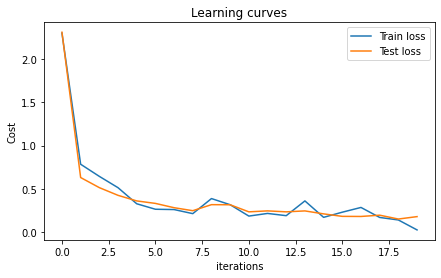

In [ ]:
# Plot the cost
plt.plot(train_costs)
plt.plot(val_costs)
plt.ylabel('Cost')
plt.xlabel('iterations')
plt.title('Learning curves')
plt.legend(['Train loss', 'Test loss'])
plt.show()

### Accuracy vs iterations

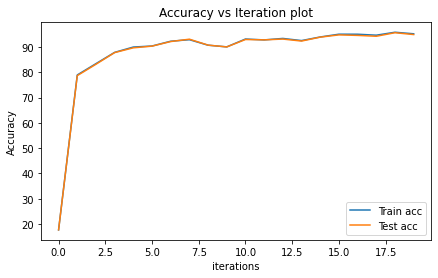

In [ ]:
# Plot the val accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.title('Accuracy vs Iteration plot')
plt.legend(['Train acc', 'Test acc'])
plt.show()

### Performance on the Test set 

Cost function value: 0.16690757870674133
Accuracy: 0.9477
Classification Report: 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.97      0.94      0.96      1032
           3       0.97      0.93      0.95      1010
           4       0.90      0.94      0.92       982
           5       0.91      0.92      0.91       892
           6       0.94      0.97      0.95       958
           7       0.98      0.95      0.96      1028
           8       0.92      0.97      0.95       974
           9       0.92      0.90      0.91      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

Confusion Matrix: 



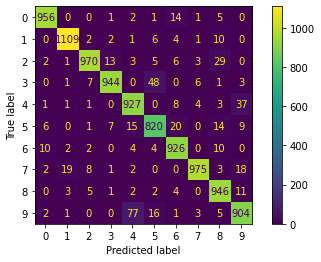

In [ ]:
for images, labels in test_loader:               
  # Forward pass only to get logits/output
  outputs = model(images.view(-1, 28, 28))
  test_cost = criterion(outputs, labels)
  print("Cost function value: " + str(test_cost.item()))

  # Get predictions from the maximum value
  _, predicted = torch.max(outputs.data, 1)

  print("Accuracy: "  + str(accuracy_score(labels.numpy(), predicted.numpy())))

  print("Classification Report: \n")
  print(classification_report(labels.numpy(), predicted.numpy(), zero_division = 0))

  print("Confusion Matrix: \n")
  cm = confusion_matrix(labels.numpy(), predicted.numpy(), labels = range(10))
  disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels = range(10))
  disp.plot()
  plt.show()

### Performance on randomly selected images

In [ ]:
images, labels = iter(test_loader).next()

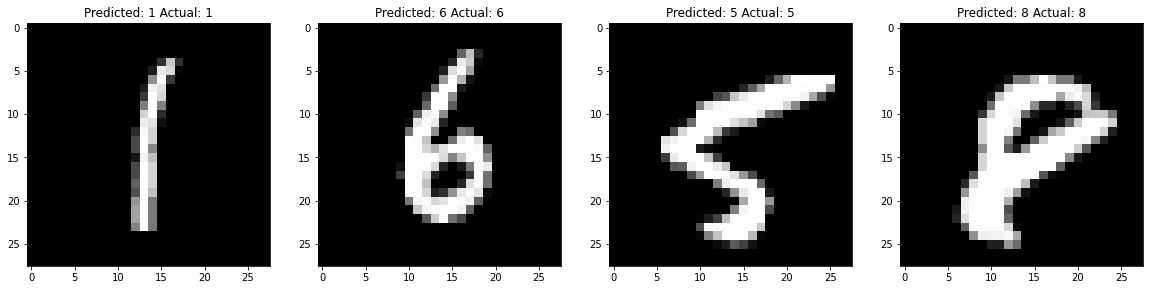

In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (20, 20))
for i in range(4):
  idx = random.randint(0, len(mnist_data_test) - 1)
  image = images[idx:idx + 1]
  label = labels[idx]
  _, predicted = torch.max(model(image.view(-1, 28, 28)).data, 1)
  ax[i].imshow(image[0, 0, :, :])
  ax[i].set_title('Predicted: {} Actual: {}'.format(predicted.item(), label.item()))

### LSTM

In [6]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers = 1):
        
        super().__init__()
        
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers = layers, batch_first = True)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        # text = text.reshape(28, BATCH_SIZE, 28)
        #text = [sent len, batch size]
        
        #embedded = [sent len, batch size, emb dim]
        
        output, (hidden, cell) = self.rnn(text)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        # assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        # hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

        return self.fc(output[:, -1, :])

In [7]:
INPUT_DIM = 28
HIDDEN_DIM = 150
OUTPUT_DIM = 10
NUM_LAYERS = 5
LR = 0.001

model = RNN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LR) #, momentum = 0.9)

In [9]:
train_costs = []
val_costs = []
train_acc = []
val_acc = []

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # inputs_reshape = inputs.reshape(28, BATCH_SIZE, 28)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.view(-1, 28, 28))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 200 == 0:
            train_costs.append(loss.item())
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            with torch.no_grad():
              for j, data in enumerate(train_loader, 0):
                images, labels = data
                # Forward pass only to get logits/output
                outputs = model(images.view(-1, 28, 28))
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
              accuracy = 100 * correct / total
              train_acc.append(accuracy)
              correct = 0
              total = 0
              for j, data in enumerate(val_loader, 0):
                images, labels = data
                # Forward pass only to get logits/output
                outputs = model(images.view(-1, 28, 28))
                val_cost = criterion(outputs, labels)
                val_costs.append(val_cost.item())
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
              accuracy = 100 * correct / total
              val_acc.append(accuracy)
              # Print Loss
              print('Epoch: {}. Iteration: {}. Train Loss: {}. Validation Accuracy: {}'.format(epoch, i, loss.item(), accuracy))

print('Finished Training')

Epoch: 0. Iteration: 0. Train Loss: 2.3079264163970947. Validation Accuracy: 9.933333396911621
Epoch: 0. Iteration: 200. Train Loss: 0.6569309830665588. Validation Accuracy: 69.78333282470703
Epoch: 0. Iteration: 400. Train Loss: 0.37728381156921387. Validation Accuracy: 90.46666717529297
Epoch: 0. Iteration: 600. Train Loss: 0.08544596284627914. Validation Accuracy: 93.5999984741211
Epoch: 1. Iteration: 0. Train Loss: 0.26060977578163147. Validation Accuracy: 94.0
Epoch: 1. Iteration: 200. Train Loss: 0.13048739731311798. Validation Accuracy: 95.4749984741211
Epoch: 1. Iteration: 400. Train Loss: 0.16586972773075104. Validation Accuracy: 95.69999694824219
Epoch: 1. Iteration: 600. Train Loss: 0.19795846939086914. Validation Accuracy: 96.25833129882812
Finished Training


### Learning curves

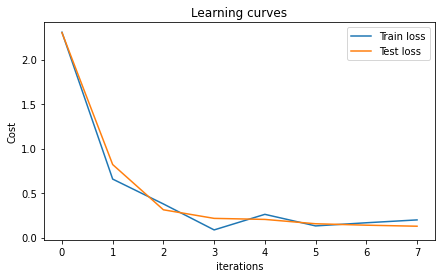

In [10]:
# Plot the cost
plt.plot(train_costs)
plt.plot(val_costs)
plt.ylabel('Cost')
plt.xlabel('iterations')
plt.title('Learning curves')
plt.legend(['Train loss', 'Test loss'])
plt.show()

### Accuracy vs iterations

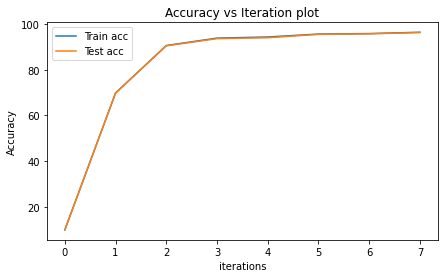

In [11]:
# Plot the val accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.title('Accuracy vs Iteration plot')
plt.legend(['Train acc', 'Test acc'])
plt.show()

### Performance on the Test set 

Cost function value: 0.13196255266666412
Accuracy: 0.9633
Classification Report: 

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       0.99      0.98      0.98      1135
           2       0.96      0.98      0.97      1032
           3       0.97      0.96      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.96      0.96      0.96       892
           6       0.97      0.99      0.98       958
           7       0.91      0.98      0.94      1028
           8       0.97      0.94      0.95       974
           9       0.95      0.90      0.93      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Confusion Matrix: 



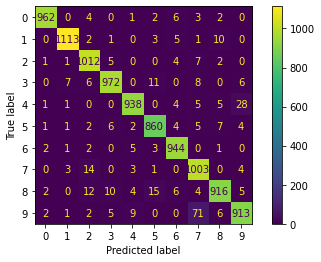

In [12]:
for images, labels in test_loader:               
  # Forward pass only to get logits/output
  outputs = model(images.view(-1, 28, 28))
  test_cost = criterion(outputs, labels)
  print("Cost function value: " + str(test_cost.item()))

  # Get predictions from the maximum value
  _, predicted = torch.max(outputs.data, 1)

  print("Accuracy: "  + str(accuracy_score(labels.numpy(), predicted.numpy())))

  print("Classification Report: \n")
  print(classification_report(labels.numpy(), predicted.numpy(), zero_division = 0))

  print("Confusion Matrix: \n")
  cm = confusion_matrix(labels.numpy(), predicted.numpy(), labels = range(10))
  disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels = range(10))
  disp.plot()
  plt.show()

### Performance on randomly selected images

In [13]:
images, labels = iter(test_loader).next()

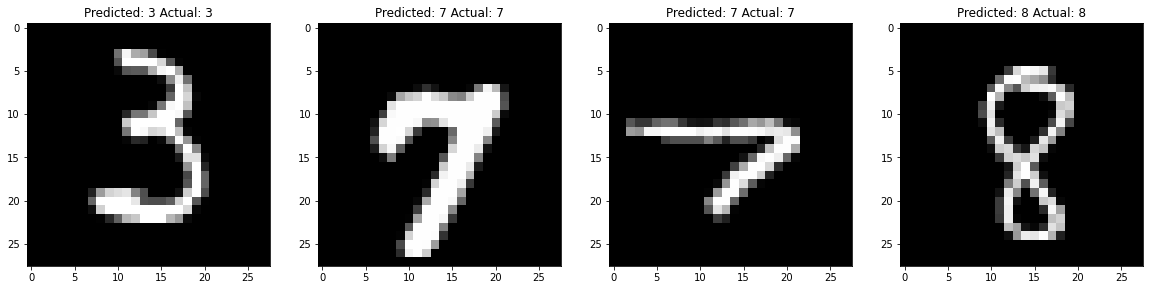

In [14]:
fig, ax = plt.subplots(1, 4, figsize = (20, 20))
for i in range(4):
  idx = random.randint(0, len(mnist_data_test) - 1)
  image = images[idx:idx + 1]
  label = labels[idx]
  _, predicted = torch.max(model(image.view(-1, 28, 28)).data, 1)
  ax[i].imshow(image[0, 0, :, :])
  ax[i].set_title('Predicted: {} Actual: {}'.format(predicted.item(), label.item()))

### Performance on custom handwritten images

In [ ]:
X = []
y = []
for i in range(10):
  a = cv.imread(str(i) + '_resize.jpg', cv.IMREAD_GRAYSCALE)
  X.append(a)
  y.append(i)

X = torch.tensor(np.array(X)).float()
y = torch.tensor(np.array(y)).long()

In [ ]:
outputs = model(X)
_, predicted = torch.max(outputs.data, 1)

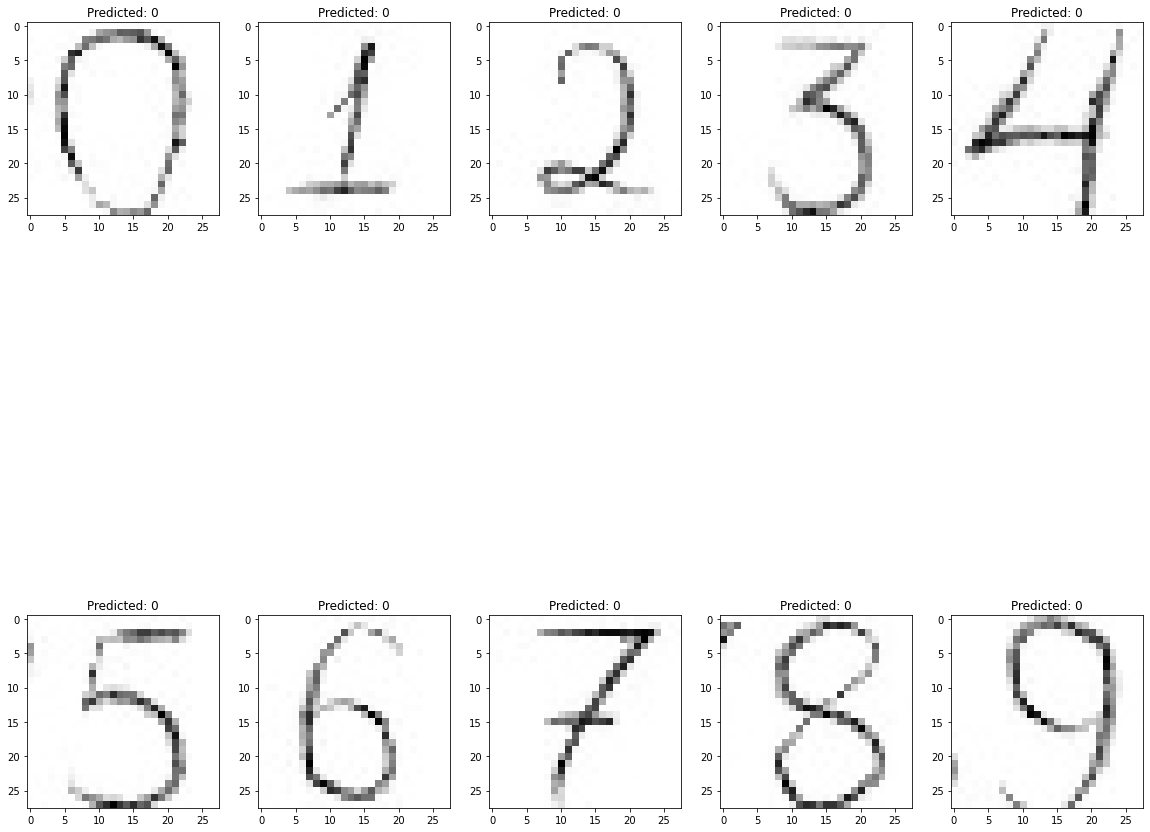

In [ ]:
fig, ax = plt.subplots(2, 5, figsize = (20, 20))
for i in range(10):
  r = i // 5
  c = i % 5
  ax[r, c].imshow(X[i, :, :].detach().numpy())
  ax[r, c].set_title('Predicted: {}'.format(predicted[i].item()))

With LSTM being the best model so far, we test it on custom handwritten digits. We can see that the model makes poor predictions. Thus, our model is not able to generalize to inputs of different format (MNIST images have a dark background compared to the custom images)

### RNN - Bidirectional

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers = 1):
        
        super().__init__()
        
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers = layers, batch_first = True, bidirectional = True)
        
        self.fc = nn.Linear(2 * hidden_dim, output_dim)
        
    def forward(self, text):
        # text = text.reshape(28, BATCH_SIZE, 28)
        #text = [sent len, batch size]
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(text)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        # assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        # hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

        return self.fc(output[:, -1, :])

In [ ]:
INPUT_DIM = 28
HIDDEN_DIM = 150
OUTPUT_DIM = 10
NUM_LAYERS = 5
LR = 0.001

model = RNN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LR) #, momentum = 0.9)

In [ ]:
train_costs = []
val_costs = []
train_acc = []
val_acc = []

for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # inputs_reshape = inputs.reshape(28, BATCH_SIZE, 28)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.view(-1, 28, 28))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 200 == 0:
            train_costs.append(loss.item())
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            with torch.no_grad():
              for j, data in enumerate(train_loader, 0):
                images, labels = data
                # Forward pass only to get logits/output
                outputs = model(images.view(-1, 28, 28))
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
              accuracy = 100 * correct / total
              train_acc.append(accuracy)
              correct = 0
              total = 0
              for j, data in enumerate(val_loader, 0):
                images, labels = data
                # Forward pass only to get logits/output
                outputs = model(images.view(-1, 28, 28))
                val_cost = criterion(outputs, labels)
                val_costs.append(val_cost.item())
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
              accuracy = 100 * correct / total
              val_acc.append(accuracy)
              # Print Loss
              print('Epoch: {}. Iteration: {}. Train Loss: {}. Validation Accuracy: {}'.format(epoch, i, loss.item(), accuracy))

print('Finished Training')

Epoch: 0. Iteration: 0. Train Loss: 2.3071086406707764. Validation Accuracy: 13.274999618530273
Epoch: 0. Iteration: 200. Train Loss: 0.5577687621116638. Validation Accuracy: 77.38333129882812
Epoch: 0. Iteration: 400. Train Loss: 0.7612340450286865. Validation Accuracy: 82.7249984741211
Epoch: 0. Iteration: 600. Train Loss: 0.2962421476840973. Validation Accuracy: 84.18333435058594
Epoch: 1. Iteration: 0. Train Loss: 0.23228172957897186. Validation Accuracy: 89.82499694824219
Epoch: 1. Iteration: 200. Train Loss: 0.212496817111969. Validation Accuracy: 92.10832977294922
Epoch: 1. Iteration: 400. Train Loss: 0.5763186812400818. Validation Accuracy: 81.73332977294922
Epoch: 1. Iteration: 600. Train Loss: 0.13227100670337677. Validation Accuracy: 92.375
Epoch: 2. Iteration: 0. Train Loss: 0.06729239225387573. Validation Accuracy: 92.42500305175781
Epoch: 2. Iteration: 200. Train Loss: 0.19752027094364166. Validation Accuracy: 92.54166412353516
Epoch: 2. Iteration: 400. Train Loss: 0.2449

### Learning curves

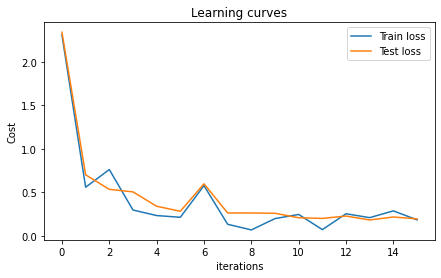

In [ ]:
# Plot the cost
plt.plot(train_costs)
plt.plot(val_costs)
plt.ylabel('Cost')
plt.xlabel('iterations')
plt.title('Learning curves')
plt.legend(['Train loss', 'Test loss'])
plt.show()

### Accuracy vs iterations

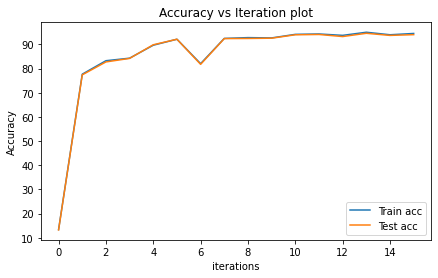

In [ ]:
# Plot the val accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.title('Accuracy vs Iteration plot')
plt.legend(['Train acc', 'Test acc'])
plt.show()

### Performance on the Test set 

Cost function value: 0.2095593959093094
Accuracy: 0.9396
Classification Report: 

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       980
           1       0.97      0.98      0.98      1135
           2       0.94      0.97      0.95      1032
           3       0.96      0.93      0.94      1010
           4       0.96      0.89      0.92       982
           5       0.88      0.93      0.91       892
           6       0.91      0.98      0.94       958
           7       0.92      0.97      0.94      1028
           8       0.95      0.92      0.94       974
           9       0.92      0.87      0.90      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

Confusion Matrix: 



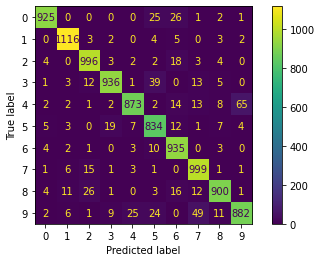

In [ ]:
for images, labels in test_loader:               
  # Forward pass only to get logits/output
  outputs = model(images.view(-1, 28, 28))
  test_cost = criterion(outputs, labels)
  print("Cost function value: " + str(test_cost.item()))

  # Get predictions from the maximum value
  _, predicted = torch.max(outputs.data, 1)

  print("Accuracy: "  + str(accuracy_score(labels.numpy(), predicted.numpy())))

  print("Classification Report: \n")
  print(classification_report(labels.numpy(), predicted.numpy(), zero_division = 0))

  print("Confusion Matrix: \n")
  cm = confusion_matrix(labels.numpy(), predicted.numpy(), labels = range(10))
  disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels = range(10))
  disp.plot()
  plt.show()

### Performance on randomly selected images

In [ ]:
images, labels = iter(test_loader).next()

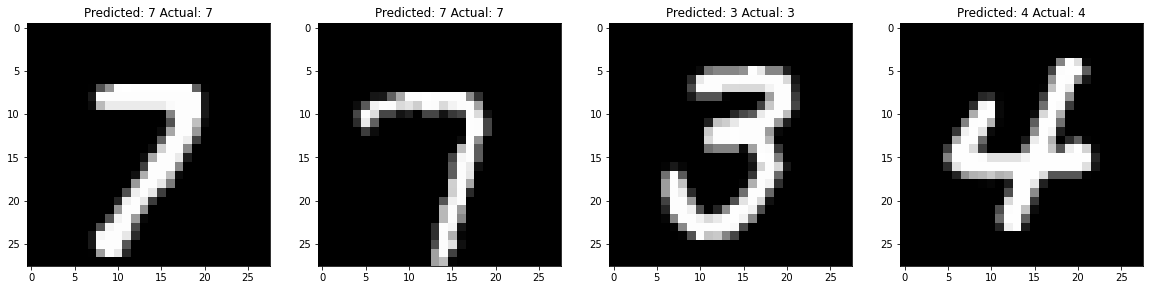

In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (20, 20))
for i in range(4):
  idx = random.randint(0, len(mnist_data_test) - 1)
  image = images[idx:idx + 1]
  label = labels[idx]
  _, predicted = torch.max(model(image.view(-1, 28, 28)).data, 1)
  ax[i].imshow(image[0, 0, :, :])
  ax[i].set_title('Predicted: {} Actual: {}'.format(predicted.item(), label.item()))

## 2. Remembering the number at a particular index in a given sequence

In [ ]:
def get_batch(K, L, pos = 1):
  seq = []
  X = np.zeros((K, L, 10))
  y = np.zeros(K)
  for i in range(K):
    a = random.sample(range(10), L)
    seq.append(a)
    X[i, range(L), a] = 1
    y[i] = a[pos]
  return seq, torch.tensor(X).float(), torch.tensor(y).long()

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers = 1):
        
        super().__init__()
        self.layers = layers
        self.hidden_dim = hidden_dim
        
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers = layers, batch_first = True)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
      
        #text = [sent len, batch size]
        #embedded = [sent len, batch size, emb dim]
        output, hidden = self.rnn(text)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        # assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        # hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

        return self.fc(output[:, -1, :])

### Hidden state size = 2

In [ ]:
INPUT_DIM = 10
HIDDEN_DIM = 2
OUTPUT_DIM = 10
NUM_LAYERS = 5
LR = 0.001
K = 64
pos = 1

model = RNN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LR) #, momentum = 0.9)

In [ ]:
train_costs = []
val_costs = []
train_acc = []
val_acc = []

for iteration in range(10*1000):
  L = random.randint(3, 10)
  _, inputs, labels = get_batch(K, L, pos = pos)
        
  # zero the parameter gradients
  optimizer.zero_grad()

  # forward + backward + optimize
  outputs = model(inputs)
  loss = criterion(outputs, labels)
  loss.backward()
  optimizer.step()
  
  train_costs.append(loss.item())
  
  # Calculate Accuracy         
  correct = 0
  total = 0
  # Iterate through test dataset
  _, predicted = torch.max(outputs.data, 1)
                
  # Total number of labels
  total += labels.size(0)
                
  # Total correct predictions
  correct += (predicted == labels).sum()
            
  accuracy = 100 * correct / total
  train_acc.append(accuracy)

  correct = 0
  total = 0
  _, inputs, labels = get_batch(K, L, pos = pos)

  # Forward pass only to get logits/output
  outputs = model(inputs)
  val_cost = criterion(outputs, labels)
  val_costs.append(val_cost.item())
                
  # Get predictions from the maximum value
  _, predicted = torch.max(outputs.data, 1)
                
  # Total number of labels
  total += labels.size(0)
                
  # Total correct predictions
  correct += (predicted == labels).sum()
            
  accuracy = 100 * correct / total
  val_acc.append(accuracy)
  # Print Loss
  print('Iteration: {}. Train Loss: {}. Validation Accuracy: {}'.format(iteration, loss.item(), accuracy))

print('Finished Training')

Streaming output truncated to the last 5000 lines.
Iteration: 5001. Train Loss: 1.7336585521697998. Validation Accuracy: 23.4375
Iteration: 5002. Train Loss: 1.6839234828948975. Validation Accuracy: 29.6875
Iteration: 5003. Train Loss: 1.7300430536270142. Validation Accuracy: 31.25
Iteration: 5004. Train Loss: 1.852378487586975. Validation Accuracy: 18.75
Iteration: 5005. Train Loss: 1.6831579208374023. Validation Accuracy: 34.375
Iteration: 5006. Train Loss: 1.5855560302734375. Validation Accuracy: 29.6875
Iteration: 5007. Train Loss: 1.6942706108093262. Validation Accuracy: 34.375
Iteration: 5008. Train Loss: 1.6877472400665283. Validation Accuracy: 17.1875
Iteration: 5009. Train Loss: 1.7153151035308838. Validation Accuracy: 31.25
Iteration: 5010. Train Loss: 1.7098232507705688. Validation Accuracy: 35.9375
Iteration: 5011. Train Loss: 1.6397866010665894. Validation Accuracy: 35.9375
Iteration: 5012. Train Loss: 1.5586049556732178. Validation Accuracy: 39.0625
Iteration: 5013. Train

### Learning curves

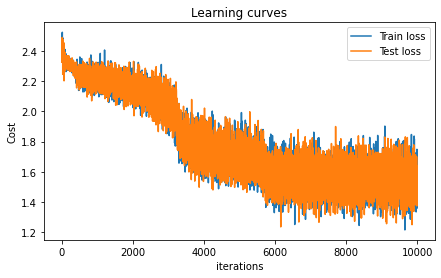

In [ ]:
# Plot the cost
plt.plot(train_costs)
plt.plot(val_costs)
plt.ylabel('Cost')
plt.xlabel('iterations')
plt.title('Learning curves')
plt.legend(['Train loss', 'Test loss'])
plt.show()

### Accuracy vs iterations

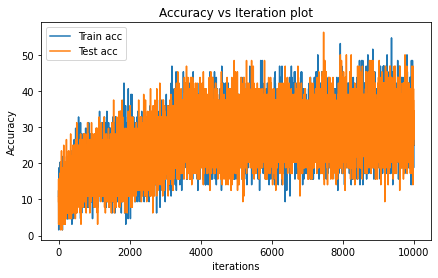

In [ ]:
# Plot the val accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.title('Accuracy vs Iteration plot')
plt.legend(['Train acc', 'Test acc'])
plt.show()

### Performance on the Test set 

Cost function value: 1.4310827255249023
Accuracy: 0.390625
Classification Report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00        10
           2       0.36      1.00      0.53         5
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       1.00      1.00      1.00        10
           6       0.00      0.00      0.00         3
           7       0.25      1.00      0.40        10
           8       0.00      0.00      0.00         7
           9       0.00      0.00      0.00         5

    accuracy                           0.39        64
   macro avg       0.16      0.30      0.19        64
weighted avg       0.22      0.39      0.26        64

Confusion Matrix: 



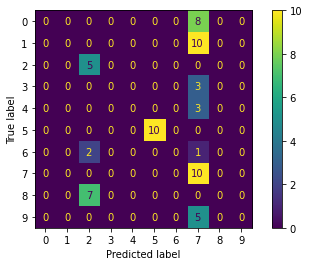

In [ ]:
L = random.randint(3, 10)
_, inputs, labels = get_batch(K, L, pos = pos)

# Forward pass only to get logits/output
outputs = model(inputs)
test_cost = criterion(outputs, labels)
print("Cost function value: " + str(test_cost.item()))

# Get predictions from the maximum value
_, predicted = torch.max(outputs.data, 1)

print("Accuracy: "  + str(accuracy_score(labels.numpy(), predicted.numpy())))

print("Classification Report: \n")
print(classification_report(labels.numpy(), predicted.numpy(), zero_division = 0))

print("Confusion Matrix: \n")
cm = confusion_matrix(labels.numpy(), predicted.numpy(), labels = range(10))
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels = range(10))
disp.plot()
plt.show()

### Hidden state size = 5

In [ ]:
INPUT_DIM = 10
HIDDEN_DIM = 5
OUTPUT_DIM = 10
NUM_LAYERS = 5
LR = 0.001
K = 64
pos = 1

model = RNN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LR) #, momentum = 0.9)

In [ ]:
train_costs = []
val_costs = []
train_acc = []
val_acc = []

for iteration in range(10*1000):
  L = random.randint(3, 10)
  _, inputs, labels = get_batch(K, L, pos = pos)
        
  # zero the parameter gradients
  optimizer.zero_grad()

  # forward + backward + optimize
  outputs = model(inputs)
  loss = criterion(outputs, labels)
  loss.backward()
  optimizer.step()
  
  train_costs.append(loss.item())
  
  # Calculate Accuracy         
  correct = 0
  total = 0
  # Iterate through test dataset
  _, predicted = torch.max(outputs.data, 1)
                
  # Total number of labels
  total += labels.size(0)
                
  # Total correct predictions
  correct += (predicted == labels).sum()
            
  accuracy = 100 * correct / total
  train_acc.append(accuracy)

  correct = 0
  total = 0
  _, inputs, labels = get_batch(K, L, pos = pos)

  # Forward pass only to get logits/output
  outputs = model(inputs)
  val_cost = criterion(outputs, labels)
  val_costs.append(val_cost.item())
                
  # Get predictions from the maximum value
  _, predicted = torch.max(outputs.data, 1)
                
  # Total number of labels
  total += labels.size(0)
                
  # Total correct predictions
  correct += (predicted == labels).sum()
            
  accuracy = 100 * correct / total
  val_acc.append(accuracy)
  # Print Loss
  print('Iteration: {}. Train Loss: {}. Validation Accuracy: {}'.format(iteration, loss.item(), accuracy))

print('Finished Training')

Streaming output truncated to the last 5000 lines.
Iteration: 5001. Train Loss: 1.3653175830841064. Validation Accuracy: 34.375
Iteration: 5002. Train Loss: 1.4070852994918823. Validation Accuracy: 34.375
Iteration: 5003. Train Loss: 1.415418028831482. Validation Accuracy: 39.0625
Iteration: 5004. Train Loss: 1.4358775615692139. Validation Accuracy: 35.9375
Iteration: 5005. Train Loss: 1.3776018619537354. Validation Accuracy: 43.75
Iteration: 5006. Train Loss: 1.219407320022583. Validation Accuracy: 35.9375
Iteration: 5007. Train Loss: 1.458021879196167. Validation Accuracy: 31.25
Iteration: 5008. Train Loss: 1.3509496450424194. Validation Accuracy: 48.4375
Iteration: 5009. Train Loss: 1.2922574281692505. Validation Accuracy: 42.1875
Iteration: 5010. Train Loss: 1.302193522453308. Validation Accuracy: 37.5
Iteration: 5011. Train Loss: 1.4463647603988647. Validation Accuracy: 39.0625
Iteration: 5012. Train Loss: 1.395965337753296. Validation Accuracy: 42.1875
Iteration: 5013. Train Loss

### Learning curves

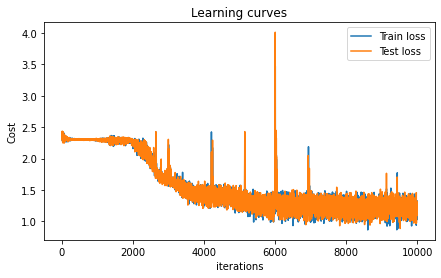

In [ ]:
# Plot the cost
plt.plot(train_costs)
plt.plot(val_costs)
plt.ylabel('Cost')
plt.xlabel('iterations')
plt.title('Learning curves')
plt.legend(['Train loss', 'Test loss'])
plt.show()

### Accuracy vs iterations

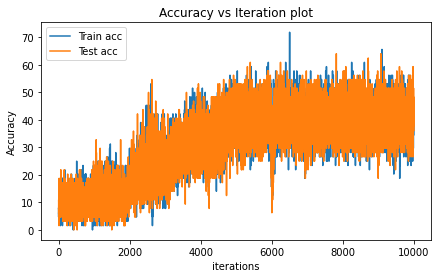

In [ ]:
# Plot the val accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.title('Accuracy vs Iteration plot')
plt.legend(['Train acc', 'Test acc'])
plt.show()

### Performance on the Test set 

Cost function value: 1.2263067960739136
Accuracy: 0.359375
Classification Report: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00         7
           6       0.15      1.00      0.27         6
           7       1.00      1.00      1.00         8
           8       0.27      1.00      0.43         3
           9       0.00      0.00      0.00         2

    accuracy                           0.36        64
   macro avg       0.24      0.40      0.27        64
weighted avg       0.25      0.36      0.26        64

Confusion Matrix: 



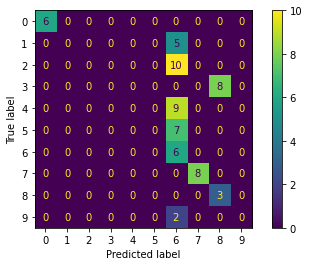

In [ ]:
L = random.randint(3, 10)
_, inputs, labels = get_batch(K, L, pos = pos)

# Forward pass only to get logits/output
outputs = model(inputs)
test_cost = criterion(outputs, labels)
print("Cost function value: " + str(test_cost.item()))

# Get predictions from the maximum value
_, predicted = torch.max(outputs.data, 1)

print("Accuracy: "  + str(accuracy_score(labels.numpy(), predicted.numpy())))

print("Classification Report: \n")
print(classification_report(labels.numpy(), predicted.numpy(), zero_division = 0))

print("Confusion Matrix: \n")
cm = confusion_matrix(labels.numpy(), predicted.numpy(), labels = range(10))
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels = range(10))
disp.plot()
plt.show()

### Hidden state size = 10

In [ ]:
INPUT_DIM = 10
HIDDEN_DIM = 10
OUTPUT_DIM = 10
NUM_LAYERS = 5
LR = 0.001
K = 64
pos = 1

model = RNN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LR) #, momentum = 0.9)

In [ ]:
train_costs = []
val_costs = []
train_acc = []
val_acc = []

for iteration in range(10*1000):
  L = random.randint(3, 10)
  _, inputs, labels = get_batch(K, L, pos = pos)
        
  # zero the parameter gradients
  optimizer.zero_grad()

  # forward + backward + optimize
  outputs = model(inputs)
  loss = criterion(outputs, labels)
  loss.backward()
  optimizer.step()
  
  train_costs.append(loss.item())
  
  # Calculate Accuracy         
  correct = 0
  total = 0
  # Iterate through test dataset
  _, predicted = torch.max(outputs.data, 1)
                
  # Total number of labels
  total += labels.size(0)
                
  # Total correct predictions
  correct += (predicted == labels).sum()
            
  accuracy = 100 * correct / total
  train_acc.append(accuracy)

  correct = 0
  total = 0
  _, inputs, labels = get_batch(K, L, pos = pos)

  # Forward pass only to get logits/output
  outputs = model(inputs)
  val_cost = criterion(outputs, labels)
  val_costs.append(val_cost.item())
                
  # Get predictions from the maximum value
  _, predicted = torch.max(outputs.data, 1)
                
  # Total number of labels
  total += labels.size(0)
                
  # Total correct predictions
  correct += (predicted == labels).sum()
            
  accuracy = 100 * correct / total
  val_acc.append(accuracy)
  # Print Loss
  print('Iteration: {}. Train Loss: {}. Validation Accuracy: {}'.format(iteration, loss.item(), accuracy))

print('Finished Training')

Streaming output truncated to the last 5000 lines.
Iteration: 5001. Train Loss: 0.08089224249124527. Validation Accuracy: 100.0
Iteration: 5002. Train Loss: 0.10918404161930084. Validation Accuracy: 100.0
Iteration: 5003. Train Loss: 0.21055129170417786. Validation Accuracy: 100.0
Iteration: 5004. Train Loss: 0.10063257068395615. Validation Accuracy: 100.0
Iteration: 5005. Train Loss: 0.10160911083221436. Validation Accuracy: 100.0
Iteration: 5006. Train Loss: 0.10075515508651733. Validation Accuracy: 100.0
Iteration: 5007. Train Loss: 0.09208465367555618. Validation Accuracy: 100.0
Iteration: 5008. Train Loss: 0.0933263748884201. Validation Accuracy: 100.0
Iteration: 5009. Train Loss: 0.08884292095899582. Validation Accuracy: 100.0
Iteration: 5010. Train Loss: 0.09730369597673416. Validation Accuracy: 100.0
Iteration: 5011. Train Loss: 0.22533993422985077. Validation Accuracy: 100.0
Iteration: 5012. Train Loss: 0.12152764201164246. Validation Accuracy: 100.0
Iteration: 5013. Train Los

### Learning curves

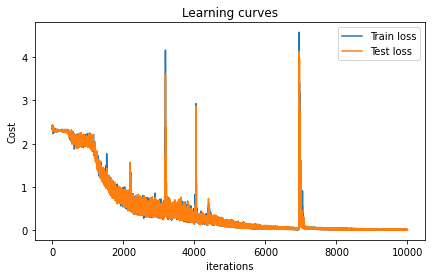

In [ ]:
# Plot the cost
plt.plot(train_costs)
plt.plot(val_costs)
plt.ylabel('Cost')
plt.xlabel('iterations')
plt.title('Learning curves')
plt.legend(['Train loss', 'Test loss'])
plt.show()

### Accuracy vs iterations

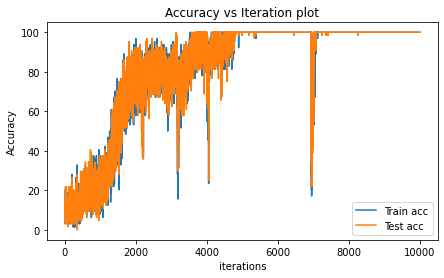

In [ ]:
# Plot the val accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.title('Accuracy vs Iteration plot')
plt.legend(['Train acc', 'Test acc'])
plt.show()

### Performance on the Test set 

Cost function value: 0.006117354147136211
Accuracy: 1.0
Classification Report: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         5

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64

Confusion Matrix: 



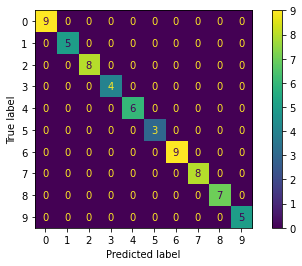

In [ ]:
L = random.randint(3, 10)
_, inputs, labels = get_batch(K, L, pos = pos)

# Forward pass only to get logits/output
outputs = model(inputs)
test_cost = criterion(outputs, labels)
print("Cost function value: " + str(test_cost.item()))

# Get predictions from the maximum value
_, predicted = torch.max(outputs.data, 1)

print("Accuracy: "  + str(accuracy_score(labels.numpy(), predicted.numpy())))

print("Classification Report: \n")
print(classification_report(labels.numpy(), predicted.numpy(), zero_division = 0))

print("Confusion Matrix: \n")
cm = confusion_matrix(labels.numpy(), predicted.numpy(), labels = range(10))
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels = range(10))
disp.plot()
plt.show()

### Performance on sample sequences of varying lengths
The best model is obtained with a hidden state size of 10

In [ ]:
L = 3
seq, inputs, labels = get_batch(5, L, pos = pos)
outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)
for i in range(5):
  # print('Sequence: ', i + 1)
  print('Input sequence: ', seq[i])
  print('Target: ', labels[i].item())
  print('Predicted value: ', predicted[i].item())
  print('\n')

Input sequence:  [7, 9, 1]
Target:  9
Predicted value:  9


Input sequence:  [1, 2, 4]
Target:  2
Predicted value:  2


Input sequence:  [0, 7, 3]
Target:  7
Predicted value:  7


Input sequence:  [3, 5, 9]
Target:  5
Predicted value:  5


Input sequence:  [9, 5, 0]
Target:  5
Predicted value:  5




In [ ]:
L = 5
seq, inputs, labels = get_batch(5, L, pos = pos)
outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)
for i in range(5):
  # print('Sequence: ', i + 1)
  print('Input sequence: ', seq[i])
  print('Target: ', labels[i].item())
  print('Predicted value: ', predicted[i].item())
  print('\n')

Input sequence:  [9, 8, 4, 2, 1]
Target:  8
Predicted value:  8


Input sequence:  [9, 4, 0, 3, 6]
Target:  4
Predicted value:  4


Input sequence:  [4, 7, 8, 1, 2]
Target:  7
Predicted value:  7


Input sequence:  [2, 0, 3, 6, 1]
Target:  0
Predicted value:  0


Input sequence:  [8, 6, 3, 2, 4]
Target:  6
Predicted value:  6




In [ ]:
L = 7
seq, inputs, labels = get_batch(5, L, pos = pos)
outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)
for i in range(5):
  # print('Sequence: ', i + 1)
  print('Input sequence: ', seq[i])
  print('Target: ', labels[i].item())
  print('Predicted value: ', predicted[i].item())
  print('\n')

Input sequence:  [9, 2, 6, 0, 5, 4, 8]
Target:  2
Predicted value:  2


Input sequence:  [0, 5, 7, 8, 4, 6, 2]
Target:  5
Predicted value:  5


Input sequence:  [2, 9, 8, 1, 7, 3, 4]
Target:  9
Predicted value:  9


Input sequence:  [4, 7, 6, 3, 9, 0, 2]
Target:  7
Predicted value:  7


Input sequence:  [9, 5, 7, 1, 4, 2, 3]
Target:  5
Predicted value:  5




In [ ]:
L = 9
seq, inputs, labels = get_batch(5, L, pos = pos)
outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)
for i in range(5):
  # print('Sequence: ', i + 1)
  print('Input sequence: ', seq[i])
  print('Target: ', labels[i].item())
  print('Predicted value: ', predicted[i].item())
  print('\n')

Input sequence:  [1, 2, 9, 8, 4, 3, 0, 5, 7]
Target:  2
Predicted value:  2


Input sequence:  [3, 1, 5, 0, 4, 6, 7, 9, 2]
Target:  1
Predicted value:  1


Input sequence:  [2, 4, 5, 7, 0, 8, 3, 6, 1]
Target:  4
Predicted value:  4


Input sequence:  [8, 4, 9, 7, 6, 5, 0, 1, 3]
Target:  4
Predicted value:  4


Input sequence:  [3, 6, 5, 8, 2, 7, 4, 1, 0]
Target:  6
Predicted value:  6




## 3. Adding two binary strings

In [37]:
def get_batch(K, L):
  max_num = (2 ** L) - 1
  X = np.zeros((K, L + 1, 2))
  y = np.zeros((K, L + 1, 1))
  for i in range(K):
    a, b = random.sample(range(max_num + 1), 2)
    c = a + b
    a_bin = bin(a)[2:]
    b_bin = bin(b)[2:]
    c_bin = bin(c)[2:]

    a_bin = ('0' * (L + 1 - len(a_bin))) + a_bin
    b_bin = ('0' * (L + 1 - len(b_bin))) + b_bin
    c_bin = ('0' * (L + 1 - len(c_bin))) + c_bin
    
    for j in range(L, -1, -1):
      if a_bin[j] == '1':
        X[i, j, 0] += 1
      if b_bin[j] == '1':
        X[i, j, 1] += 1
      if c_bin[j] == '1':
        y[i, j, 0] += 1
  return torch.tensor(X).float(), torch.tensor(y).long()

In [38]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers = 1):
        
        super().__init__()
        self.layers = layers
        self.hidden_dim = hidden_dim
        
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers = layers, batch_first = True)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
      
        #text = [sent len, batch size]
        #embedded = [sent len, batch size, emb dim]
        output, (hidden, cell) = self.rnn(text)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        # assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        # hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

        return self.fc(output)

### Hidden state size = 2

In [ ]:
INPUT_DIM = 2
HIDDEN_DIM = 2
OUTPUT_DIM = 2
NUM_LAYERS = 5
LR = 0.001
K = 64
L = 5

model = RNN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LR) #, momentum = 0.9)

In [ ]:
train_costs = []
val_costs = []
train_acc = []
val_acc = []

for iteration in range(5000):
  inputs, labels = get_batch(K, L)
  labels = labels.flatten()

  # zero the parameter gradients
  optimizer.zero_grad()

  # forward + backward + optimize
  outputs = model(inputs)
  loss = criterion(outputs.view(-1, 2), labels)
  loss.backward()
  optimizer.step()
  
  train_costs.append(loss.item())
  
  # Calculate Accuracy         
  correct = 0
  total = 0
  # Iterate through test dataset
  _, predicted = torch.max(outputs.view(-1, 2).data, 1)
                
  # Total number of labels
  total += labels.size(0)
                
  # Total correct predictions
  correct += (predicted == labels).sum()
            
  accuracy = 100 * correct / total
  train_acc.append(accuracy)

  correct = 0
  total = 0
  inputs, labels = get_batch(K, L)
  labels = labels.flatten()

  # Forward pass only to get logits/output
  outputs = model(inputs)
  val_cost = criterion(outputs.view(-1, 2), labels)
  val_costs.append(val_cost.item())
                
  # Get predictions from the maximum value
  _, predicted = torch.max(outputs.view(-1, 2).data, 1)
                
  # Total number of labels
  total += labels.size(0)
                
  # Total correct predictions
  correct += (predicted == labels).sum()
            
  accuracy = 100 * correct / total
  val_acc.append(accuracy)
  # Print Loss
  print('Iteration: {}. Train Loss: {}. Validation Accuracy: {}'.format(iteration, loss.item(), accuracy))

print('Finished Training')

Streaming output truncated to the last 5000 lines.
Iteration: 1. Train Loss: 0.6964406967163086. Validation Accuracy: 46.35416793823242
Iteration: 2. Train Loss: 0.6946040987968445. Validation Accuracy: 53.90625
Iteration: 3. Train Loss: 0.6912806630134583. Validation Accuracy: 46.09375
Iteration: 4. Train Loss: 0.6934769749641418. Validation Accuracy: 51.82291793823242
Iteration: 5. Train Loss: 0.6934767365455627. Validation Accuracy: 50.78125
Iteration: 6. Train Loss: 0.6929764747619629. Validation Accuracy: 53.125
Iteration: 7. Train Loss: 0.6942999362945557. Validation Accuracy: 50.52083206176758
Iteration: 8. Train Loss: 0.6950550079345703. Validation Accuracy: 50.0
Iteration: 9. Train Loss: 0.6957116723060608. Validation Accuracy: 50.52083206176758
Iteration: 10. Train Loss: 0.6941995024681091. Validation Accuracy: 51.30208206176758
Iteration: 11. Train Loss: 0.6918745040893555. Validation Accuracy: 50.52083206176758
Iteration: 12. Train Loss: 0.6939189434051514. Validation Accur

### Learning curves

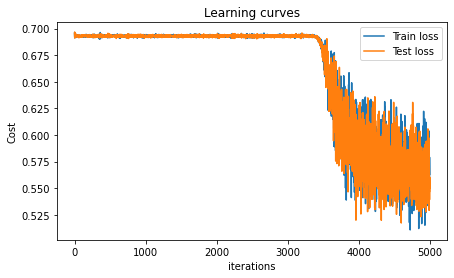

In [ ]:
# Plot the cost
plt.plot(train_costs)
plt.plot(val_costs)
plt.ylabel('Cost')
plt.xlabel('iterations')
plt.title('Learning curves')
plt.legend(['Train loss', 'Test loss'])
plt.show()

### Accuracy vs iterations

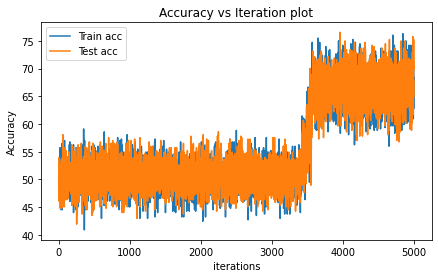

In [ ]:
# Plot the val accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.title('Accuracy vs Iteration plot')
plt.legend(['Train acc', 'Test acc'])
plt.show()

### Accuracy vs L

In [ ]:
acc = []
for L in range(1, 21):
  inputs, labels = get_batch(100, L)
  outputs = model(inputs)
  _, predicted = torch.max(outputs.view(-1, 2).data, 1)
  acc.append(accuracy_score(labels.flatten().numpy(), predicted.numpy()))

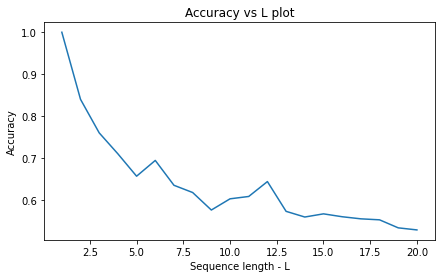

In [ ]:
# Plot the val accuracy
plt.plot(range(1, 21), acc)
plt.ylabel('Accuracy')
plt.xlabel('Sequence length - L')
plt.title('Accuracy vs L plot')
plt.show()

### Hidden state size = 5

In [ ]:
INPUT_DIM = 2
HIDDEN_DIM = 5
OUTPUT_DIM = 2
NUM_LAYERS = 5
LR = 0.001
K = 64
L = 5

model = RNN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LR) #, momentum = 0.9)

In [ ]:
train_costs = []
val_costs = []
train_acc = []
val_acc = []

for iteration in range(5000):
  inputs, labels = get_batch(K, L)
  labels = labels.flatten()

  # zero the parameter gradients
  optimizer.zero_grad()

  # forward + backward + optimize
  outputs = model(inputs)
  loss = criterion(outputs.view(-1, 2), labels)
  loss.backward()
  optimizer.step()
  
  train_costs.append(loss.item())
  
  # Calculate Accuracy         
  correct = 0
  total = 0
  # Iterate through test dataset
  _, predicted = torch.max(outputs.view(-1, 2).data, 1)
                
  # Total number of labels
  total += labels.size(0)
                
  # Total correct predictions
  correct += (predicted == labels).sum()
            
  accuracy = 100 * correct / total
  train_acc.append(accuracy)

  correct = 0
  total = 0
  inputs, labels = get_batch(K, L)
  labels = labels.flatten()

  # Forward pass only to get logits/output
  outputs = model(inputs)
  val_cost = criterion(outputs.view(-1, 2), labels)
  val_costs.append(val_cost.item())
                
  # Get predictions from the maximum value
  _, predicted = torch.max(outputs.view(-1, 2).data, 1)
                
  # Total number of labels
  total += labels.size(0)
                
  # Total correct predictions
  correct += (predicted == labels).sum()
            
  accuracy = 100 * correct / total
  val_acc.append(accuracy)
  # Print Loss
  print('Iteration: {}. Train Loss: {}. Validation Accuracy: {}'.format(iteration, loss.item(), accuracy))

print('Finished Training')

Streaming output truncated to the last 5000 lines.
Iteration: 1. Train Loss: 0.6938777565956116. Validation Accuracy: 48.69791793823242
Iteration: 2. Train Loss: 0.6985463500022888. Validation Accuracy: 51.82291793823242
Iteration: 3. Train Loss: 0.695241391658783. Validation Accuracy: 53.125
Iteration: 4. Train Loss: 0.6992513537406921. Validation Accuracy: 52.86458206176758
Iteration: 5. Train Loss: 0.696704626083374. Validation Accuracy: 48.4375
Iteration: 6. Train Loss: 0.6925461292266846. Validation Accuracy: 48.4375
Iteration: 7. Train Loss: 0.6955514550209045. Validation Accuracy: 48.95833206176758
Iteration: 8. Train Loss: 0.6974673271179199. Validation Accuracy: 49.73958206176758
Iteration: 9. Train Loss: 0.6945679187774658. Validation Accuracy: 51.04166793823242
Iteration: 10. Train Loss: 0.6932434439659119. Validation Accuracy: 48.69791793823242
Iteration: 11. Train Loss: 0.6906557679176331. Validation Accuracy: 51.30208206176758
Iteration: 12. Train Loss: 0.6918232440948486

### Learning curves

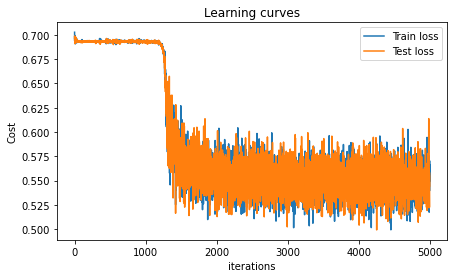

In [ ]:
# Plot the cost
plt.plot(train_costs)
plt.plot(val_costs)
plt.ylabel('Cost')
plt.xlabel('iterations')
plt.title('Learning curves')
plt.legend(['Train loss', 'Test loss'])
plt.show()

### Accuracy vs iterations

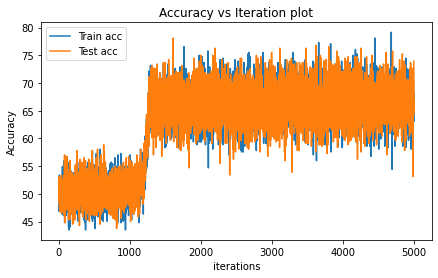

In [ ]:
# Plot the val accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.title('Accuracy vs Iteration plot')
plt.legend(['Train acc', 'Test acc'])
plt.show()

### Accuracy vs L

In [ ]:
acc = []
for L in range(1, 21):
  inputs, labels = get_batch(100, L)
  outputs = model(inputs)
  _, predicted = torch.max(outputs.view(-1, 2).data, 1)
  acc.append(accuracy_score(labels.flatten().numpy(), predicted.numpy()))

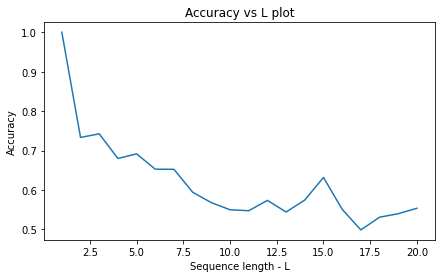

In [ ]:
# Plot the val accuracy
plt.plot(range(1, 21), acc)
plt.ylabel('Accuracy')
plt.xlabel('Sequence length - L')
plt.title('Accuracy vs L plot')
plt.show()

### Hidden state size = 10

In [ ]:
INPUT_DIM = 2
HIDDEN_DIM = 10
OUTPUT_DIM = 2
NUM_LAYERS = 5
LR = 0.001
K = 64
L = 5

model = RNN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LR) #, momentum = 0.9)

In [ ]:
train_costs = []
val_costs = []
train_acc = []
val_acc = []

for iteration in range(5000):
  inputs, labels = get_batch(K, L)
  labels = labels.flatten()

  # zero the parameter gradients
  optimizer.zero_grad()

  # forward + backward + optimize
  outputs = model(inputs)
  loss = criterion(outputs.view(-1, 2), labels)
  loss.backward()
  optimizer.step()
  
  train_costs.append(loss.item())
  
  # Calculate Accuracy         
  correct = 0
  total = 0
  # Iterate through test dataset
  _, predicted = torch.max(outputs.view(-1, 2).data, 1)
                
  # Total number of labels
  total += labels.size(0)
                
  # Total correct predictions
  correct += (predicted == labels).sum()
            
  accuracy = 100 * correct / total
  train_acc.append(accuracy)

  correct = 0
  total = 0
  inputs, labels = get_batch(K, L)
  labels = labels.flatten()

  # Forward pass only to get logits/output
  outputs = model(inputs)
  val_cost = criterion(outputs.view(-1, 2), labels)
  val_costs.append(val_cost.item())
                
  # Get predictions from the maximum value
  _, predicted = torch.max(outputs.view(-1, 2).data, 1)
                
  # Total number of labels
  total += labels.size(0)
                
  # Total correct predictions
  correct += (predicted == labels).sum()
            
  accuracy = 100 * correct / total
  val_acc.append(accuracy)
  # Print Loss
  print('Iteration: {}. Train Loss: {}. Validation Accuracy: {}'.format(iteration, loss.item(), accuracy))

print('Finished Training')

Streaming output truncated to the last 5000 lines.
Iteration: 1. Train Loss: 0.6985061764717102. Validation Accuracy: 48.17708206176758
Iteration: 2. Train Loss: 0.7001374363899231. Validation Accuracy: 47.13541793823242
Iteration: 3. Train Loss: 0.6970900893211365. Validation Accuracy: 49.73958206176758
Iteration: 4. Train Loss: 0.69525545835495. Validation Accuracy: 50.78125
Iteration: 5. Train Loss: 0.6918273568153381. Validation Accuracy: 53.90625
Iteration: 6. Train Loss: 0.6947813630104065. Validation Accuracy: 48.69791793823242
Iteration: 7. Train Loss: 0.6952977776527405. Validation Accuracy: 52.86458206176758
Iteration: 8. Train Loss: 0.6904236674308777. Validation Accuracy: 53.90625
Iteration: 9. Train Loss: 0.6947624683380127. Validation Accuracy: 50.0
Iteration: 10. Train Loss: 0.6945505738258362. Validation Accuracy: 50.78125
Iteration: 11. Train Loss: 0.6947948336601257. Validation Accuracy: 48.95833206176758
Iteration: 12. Train Loss: 0.6943961977958679. Validation Accur

### Learning curves

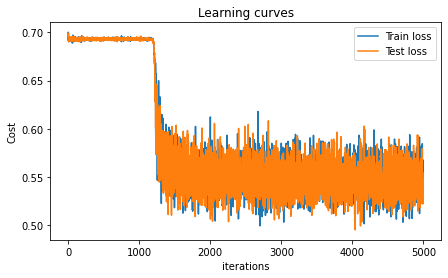

In [ ]:
# Plot the cost
plt.plot(train_costs)
plt.plot(val_costs)
plt.ylabel('Cost')
plt.xlabel('iterations')
plt.title('Learning curves')
plt.legend(['Train loss', 'Test loss'])
plt.show()

### Accuracy vs iterations

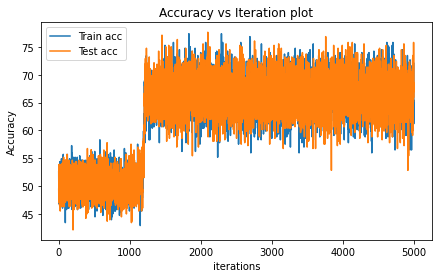

In [ ]:
# Plot the val accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.title('Accuracy vs Iteration plot')
plt.legend(['Train acc', 'Test acc'])
plt.show()

### Accuracy vs L

In [ ]:
acc = []
for L in range(1, 21):
  inputs, labels = get_batch(100, L)
  outputs = model(inputs)
  _, predicted = torch.max(outputs.view(-1, 2).data, 1)
  acc.append(accuracy_score(labels.flatten().numpy(), predicted.numpy()))

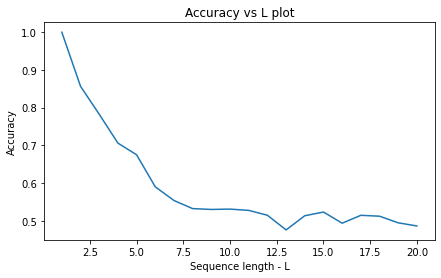

In [ ]:
# Plot the val accuracy
plt.plot(range(1, 21), acc)
plt.ylabel('Accuracy')
plt.xlabel('Sequence length - L')
plt.title('Accuracy vs L plot')
plt.show()

When we vary the state vector size (2, 5, 10), the average accuracy remains more or less the same with no significant gains

## MSE Loss vs Cross Entropy

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers = 1):
        
        super().__init__()
        self.layers = layers
        self.hidden_dim = hidden_dim
        
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers = layers, batch_first = True)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
      
        #text = [sent len, batch size]
        #embedded = [sent len, batch size, emb dim]
        output, (hidden, cell) = self.rnn(text)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        # assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        # hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

        return F.softmax(self.fc(output), dim = -1)

In [ ]:
INPUT_DIM = 2
HIDDEN_DIM = 5
OUTPUT_DIM = 2
NUM_LAYERS = 5
LR = 0.001
K = 64
L = 5

model = RNN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = LR) #, momentum = 0.9)

In [ ]:
train_costs = []
val_costs = []
train_acc = []
val_acc = []

for iteration in range(5000):
  inputs, labels = get_batch(K, L)
  labels = labels.flatten()

  # zero the parameter gradients
  optimizer.zero_grad()

  # forward + backward + optimize
  outputs = model(inputs)
  loss = criterion(outputs.view(-1, 2)[:, -1], labels.float())
  loss.backward()
  optimizer.step()
  
  train_costs.append(loss.item())
  
  # Calculate Accuracy         
  correct = 0
  total = 0
  # Iterate through test dataset
  _, predicted = torch.max(outputs.view(-1, 2).data, 1)
                
  # Total number of labels
  total += labels.size(0)
                
  # Total correct predictions
  correct += (predicted == labels).sum()
            
  accuracy = 100 * correct / total
  train_acc.append(accuracy)

  correct = 0
  total = 0
  inputs, labels = get_batch(K, L)
  labels = labels.flatten()

  # Forward pass only to get logits/output
  outputs = model(inputs)
  val_cost = criterion(outputs.view(-1, 2)[:, -1], labels.float())
  val_costs.append(val_cost.item())
                
  # Get predictions from the maximum value
  _, predicted = torch.max(outputs.view(-1, 2).data, 1)
                
  # Total number of labels
  total += labels.size(0)
                
  # Total correct predictions
  correct += (predicted == labels).sum()
            
  accuracy = 100 * correct / total
  val_acc.append(accuracy)
  # Print Loss
  print('Iteration: {}. Train Loss: {}. Validation Accuracy: {}'.format(iteration, loss.item(), accuracy))

print('Finished Training')

Streaming output truncated to the last 5000 lines.
Iteration: 1. Train Loss: 0.2527525722980499. Validation Accuracy: 46.35416793823242
Iteration: 2. Train Loss: 0.2508527934551239. Validation Accuracy: 47.39583206176758
Iteration: 3. Train Loss: 0.2529959976673126. Validation Accuracy: 48.17708206176758
Iteration: 4. Train Loss: 0.25171905755996704. Validation Accuracy: 49.47916793823242
Iteration: 5. Train Loss: 0.25061464309692383. Validation Accuracy: 48.17708206176758
Iteration: 6. Train Loss: 0.2512994408607483. Validation Accuracy: 51.82291793823242
Iteration: 7. Train Loss: 0.25148963928222656. Validation Accuracy: 52.08333206176758
Iteration: 8. Train Loss: 0.25171810388565063. Validation Accuracy: 50.26041793823242
Iteration: 9. Train Loss: 0.25158411264419556. Validation Accuracy: 48.69791793823242
Iteration: 10. Train Loss: 0.2510802149772644. Validation Accuracy: 49.47916793823242
Iteration: 11. Train Loss: 0.2521497905254364. Validation Accuracy: 51.30208206176758
Iterati

### Learning curves

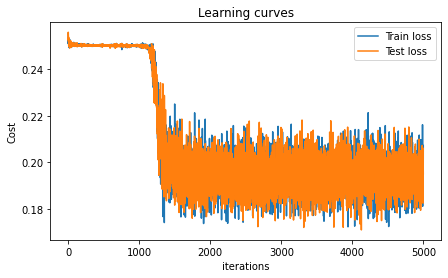

In [ ]:
# Plot the cost
plt.plot(train_costs)
plt.plot(val_costs)
plt.ylabel('Cost')
plt.xlabel('iterations')
plt.title('Learning curves')
plt.legend(['Train loss', 'Test loss'])
plt.show()

### Accuracy vs iterations

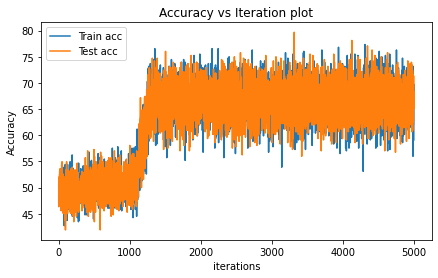

In [ ]:
# Plot the val accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.title('Accuracy vs Iteration plot')
plt.legend(['Train acc', 'Test acc'])
plt.show()

### Accuracy vs L

In [ ]:
acc = []
for L in range(1, 21):
  inputs, labels = get_batch(100, L)
  outputs = model(inputs)
  _, predicted = torch.max(outputs.view(-1, 2).data, 1)
  acc.append(accuracy_score(labels.flatten().numpy(), predicted.numpy()))

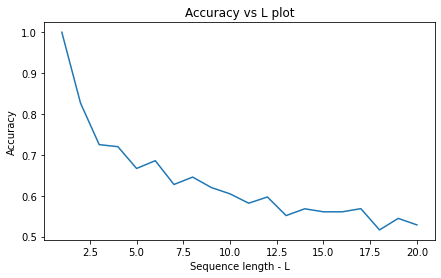

In [ ]:
# Plot the val accuracy
plt.plot(range(1, 21), acc)
plt.ylabel('Accuracy')
plt.xlabel('Sequence length - L')
plt.title('Accuracy vs L plot')
plt.show()

We trained the network with hidden state size of 5 but with MSE loss. The average accuracy is 68% compared to 74% when trained with cross entropy loss (with same hidden state size)

For all the above experiments, we have fixed L = 5 during training. We have provided the average accuracy vs L plot during inference. The average accuracy falls as L increases. We now train networks with L = 3 and L = 10 with hidden state size = 5

### L = 3

In [39]:
INPUT_DIM = 2
HIDDEN_DIM = 5
OUTPUT_DIM = 2
NUM_LAYERS = 5
LR = 0.001
K = 64
L = 3

model = RNN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS)

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LR) #, momentum = 0.9)

In [41]:
train_costs = []
val_costs = []
train_acc = []
val_acc = []

for iteration in range(5000):
  inputs, labels = get_batch(K, L)
  labels = labels.flatten()

  # zero the parameter gradients
  optimizer.zero_grad()

  # forward + backward + optimize
  outputs = model(inputs)
  loss = criterion(outputs.view(-1, 2), labels)
  loss.backward()
  optimizer.step()
  
  train_costs.append(loss.item())
  
  # Calculate Accuracy         
  correct = 0
  total = 0
  # Iterate through test dataset
  _, predicted = torch.max(outputs.view(-1, 2).data, 1)
                
  # Total number of labels
  total += labels.size(0)
                
  # Total correct predictions
  correct += (predicted == labels).sum()
            
  accuracy = 100 * correct / total
  train_acc.append(accuracy)

  correct = 0
  total = 0
  inputs, labels = get_batch(K, L)
  labels = labels.flatten()

  # Forward pass only to get logits/output
  outputs = model(inputs)
  val_cost = criterion(outputs.view(-1, 2), labels)
  val_costs.append(val_cost.item())
                
  # Get predictions from the maximum value
  _, predicted = torch.max(outputs.view(-1, 2).data, 1)
                
  # Total number of labels
  total += labels.size(0)
                
  # Total correct predictions
  correct += (predicted == labels).sum()
            
  accuracy = 100 * correct / total
  val_acc.append(accuracy)
  # Print Loss
  print('Iteration: {}. Train Loss: {}. Validation Accuracy: {}'.format(iteration, loss.item(), accuracy))

print('Finished Training')

Streaming output truncated to the last 5000 lines.
Iteration: 1. Train Loss: 0.7131499648094177. Validation Accuracy: 53.125
Iteration: 2. Train Loss: 0.715872585773468. Validation Accuracy: 50.390625
Iteration: 3. Train Loss: 0.7282714247703552. Validation Accuracy: 49.21875
Iteration: 4. Train Loss: 0.7169039845466614. Validation Accuracy: 46.09375
Iteration: 5. Train Loss: 0.7142415642738342. Validation Accuracy: 52.34375
Iteration: 6. Train Loss: 0.7126679420471191. Validation Accuracy: 51.5625
Iteration: 7. Train Loss: 0.7204973697662354. Validation Accuracy: 49.609375
Iteration: 8. Train Loss: 0.7224205732345581. Validation Accuracy: 51.171875
Iteration: 9. Train Loss: 0.7138694524765015. Validation Accuracy: 46.484375
Iteration: 10. Train Loss: 0.7069961428642273. Validation Accuracy: 51.171875
Iteration: 11. Train Loss: 0.7120761275291443. Validation Accuracy: 46.09375
Iteration: 12. Train Loss: 0.7107518315315247. Validation Accuracy: 52.34375
Iteration: 13. Train Loss: 0.7107

### Learning curves

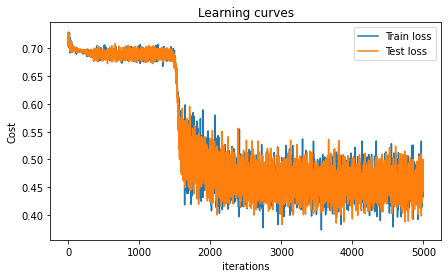

In [42]:
# Plot the cost
plt.plot(train_costs)
plt.plot(val_costs)
plt.ylabel('Cost')
plt.xlabel('iterations')
plt.title('Learning curves')
plt.legend(['Train loss', 'Test loss'])
plt.show()

### Accuracy vs iterations

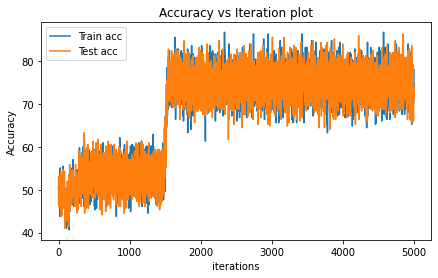

In [43]:
# Plot the val accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.title('Accuracy vs Iteration plot')
plt.legend(['Train acc', 'Test acc'])
plt.show()

### Accuracy vs L

In [44]:
acc = []
for L in range(1, 21):
  inputs, labels = get_batch(100, L)
  outputs = model(inputs)
  _, predicted = torch.max(outputs.view(-1, 2).data, 1)
  acc.append(accuracy_score(labels.flatten().numpy(), predicted.numpy()))

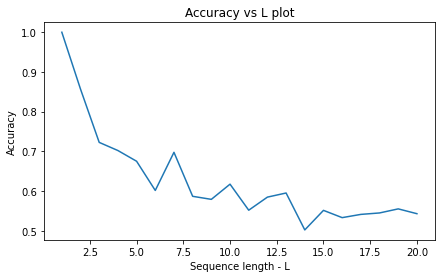

In [45]:
# Plot the val accuracy
plt.plot(range(1, 21), acc)
plt.ylabel('Accuracy')
plt.xlabel('Sequence length - L')
plt.title('Accuracy vs L plot')
plt.show()

### L = 10

In [46]:
INPUT_DIM = 2
HIDDEN_DIM = 5
OUTPUT_DIM = 2
NUM_LAYERS = 5
LR = 0.001
K = 64
L = 10

model = RNN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS)

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LR) #, momentum = 0.9)

In [48]:
train_costs = []
val_costs = []
train_acc = []
val_acc = []

for iteration in range(5000):
  inputs, labels = get_batch(K, L)
  labels = labels.flatten()

  # zero the parameter gradients
  optimizer.zero_grad()

  # forward + backward + optimize
  outputs = model(inputs)
  loss = criterion(outputs.view(-1, 2), labels)
  loss.backward()
  optimizer.step()
  
  train_costs.append(loss.item())
  
  # Calculate Accuracy         
  correct = 0
  total = 0
  # Iterate through test dataset
  _, predicted = torch.max(outputs.view(-1, 2).data, 1)
                
  # Total number of labels
  total += labels.size(0)
                
  # Total correct predictions
  correct += (predicted == labels).sum()
            
  accuracy = 100 * correct / total
  train_acc.append(accuracy)

  correct = 0
  total = 0
  inputs, labels = get_batch(K, L)
  labels = labels.flatten()

  # Forward pass only to get logits/output
  outputs = model(inputs)
  val_cost = criterion(outputs.view(-1, 2), labels)
  val_costs.append(val_cost.item())
                
  # Get predictions from the maximum value
  _, predicted = torch.max(outputs.view(-1, 2).data, 1)
                
  # Total number of labels
  total += labels.size(0)
                
  # Total correct predictions
  correct += (predicted == labels).sum()
            
  accuracy = 100 * correct / total
  val_acc.append(accuracy)
  # Print Loss
  print('Iteration: {}. Train Loss: {}. Validation Accuracy: {}'.format(iteration, loss.item(), accuracy))

print('Finished Training')

Streaming output truncated to the last 5000 lines.
Iteration: 1. Train Loss: 0.7009475231170654. Validation Accuracy: 48.4375
Iteration: 2. Train Loss: 0.6908105611801147. Validation Accuracy: 50.994319915771484
Iteration: 3. Train Loss: 0.6949511170387268. Validation Accuracy: 48.72159194946289
Iteration: 4. Train Loss: 0.6956255435943604. Validation Accuracy: 48.4375
Iteration: 5. Train Loss: 0.6989268660545349. Validation Accuracy: 49.85795593261719
Iteration: 6. Train Loss: 0.6936454176902771. Validation Accuracy: 50.28409194946289
Iteration: 7. Train Loss: 0.6977441310882568. Validation Accuracy: 51.42045593261719
Iteration: 8. Train Loss: 0.6951209306716919. Validation Accuracy: 50.852272033691406
Iteration: 9. Train Loss: 0.6979852318763733. Validation Accuracy: 49.5738639831543
Iteration: 10. Train Loss: 0.6940798163414001. Validation Accuracy: 51.42045593261719
Iteration: 11. Train Loss: 0.6948841214179993. Validation Accuracy: 52.272727966308594
Iteration: 12. Train Loss: 0.6

### Learning curves

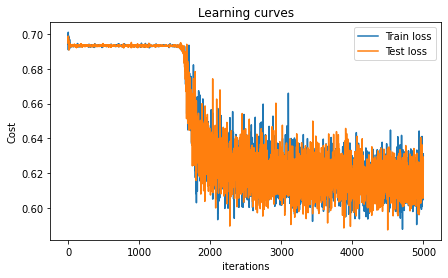

In [49]:
# Plot the cost
plt.plot(train_costs)
plt.plot(val_costs)
plt.ylabel('Cost')
plt.xlabel('iterations')
plt.title('Learning curves')
plt.legend(['Train loss', 'Test loss'])
plt.show()

### Accuracy vs iterations

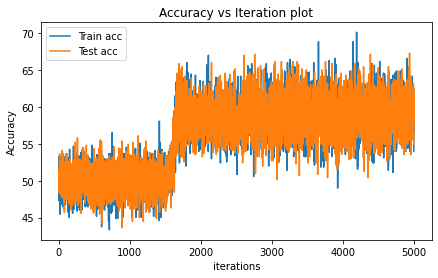

In [50]:
# Plot the val accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.title('Accuracy vs Iteration plot')
plt.legend(['Train acc', 'Test acc'])
plt.show()

### Accuracy vs L

In [51]:
acc = []
for L in range(1, 21):
  inputs, labels = get_batch(100, L)
  outputs = model(inputs)
  _, predicted = torch.max(outputs.view(-1, 2).data, 1)
  acc.append(accuracy_score(labels.flatten().numpy(), predicted.numpy()))

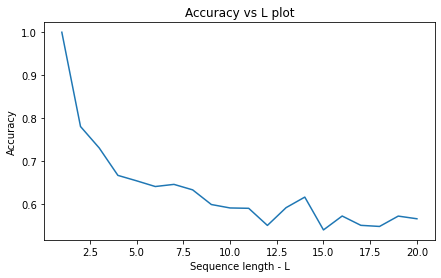

In [52]:
# Plot the val accuracy
plt.plot(range(1, 21), acc)
plt.ylabel('Accuracy')
plt.xlabel('Sequence length - L')
plt.title('Accuracy vs L plot')
plt.show()

The trend remains the same even when trained on larger values of L. This is because the network has to model long-range dependencies as L increases